## GSD test


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier
import subprocess
import utils
from snsynth import Synthesizer
from snsynth.gsd import GSDSynthesizer
import time
"""

Test on the following data types: 
1) High cardinality
2) Real valued.
3) Highly correlated.

"""

For GSD support, please install jax: pip install --upgrade  "jax[cuda11_cudnn82]==0.4.6" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


'\n\nTest on the following data types: \n1) High cardinality\n2) Real valued.\n3) Highly correlated.\n\n'

# Adult (Categorical only)

In [2]:
git_root_dir = subprocess.check_output("git rev-parse --show-toplevel".split(" ")).decode("utf-8").strip()
meta_path = os.path.join(git_root_dir, os.path.join("datasets", "PUMS_pid.yaml"))
csv_path = os.path.join(git_root_dir, os.path.join("datasets", "PUMS_pid.csv"))
# csv_path = os.path.join(git_root_dir, os.path.join("datasets", "PUMS.csv"))

df = pd.read_csv(csv_path, index_col=None).astype(str)
df = df.drop(["income", "pid", "age"], axis=1)

nf = df.to_numpy().astype(int)

In [3]:
# Still need to implement 
synth = GSDSynthesizer(10000.0, 1e-5, verbose=True)
synth.fit(df, genetic_operators=['mutate', 'cross'])

sync_data = synth.sample()

/Users/giuseppevietri/Code/smartnoise-sdk-gsd/synth/snsynth/gsd/gsd.py:105: UserWarning: Must split privacy budget
  warnings.warn("Must split privacy budget")



Cond.Marginal= ['sex'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['educ'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['race'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['married'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=26
Cond.Marginal= ['sex', 'educ'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['sex', 'race'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['sex', 'married'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['educ', 'race'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['educ', 'married'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['race', 'married'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=188
Statistics size = 214
Gen=0   : fitness=0.582045.
Gen=1000: fitness=0.000113838.
Gen=2000: fitness=5.10213e-05.
Gen=3000: fitness=4.70628e-05.
Gen=4000: fitness=4.70628e-05.
Gen=5000: fitness=4.70628e-05.
Gen=6000: fitness=4.70628e-05.
		 ###

In [ ]:
synth = GSDSynthesizer(10000.0, 1e-5, verbose=True)
synth.fit(df, genetic_operators=['mutate'])

sync_data = synth.sample()

# High cardinality

In [4]:
import time
rng = np.random.default_rng(0)

d = 1
ordinal_columns = 'categorical_1'
cat_cardinality = 10000
N = 2 * cat_cardinality

data_np = rng.integers(0, cat_cardinality, (N, d ))
data_np[:cat_cardinality, 0] = 0
data_np = data_np.astype(str)
data_df = pd.DataFrame(data_np, columns=[ordinal_columns])


t0 = time.time()
synth = GSDSynthesizer(3000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(data_np, N_prime=1000, genetic_operators=['mutate', 'cross'])
print(f'elapsed time = {time.time() - t0}')

max_error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy())).max()
print(f'Statistical error:', max_error)

/Users/giuseppevietri/Code/smartnoise-sdk-gsd/synth/snsynth/gsd/gsd.py:105: UserWarning: Must split privacy budget
  warnings.warn("Must split privacy budget")



Cond.Marginal= [0] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=6328
Statistics size = 6328
Gen=0   : fitness=0.250097.
Gen=1000: fitness=0.00227959.
Gen=2000: fitness=0.000381281.
Gen=3000: fitness=0.000377697.
Gen=4000: fitness=0.000377035.
Gen=5000: fitness=0.000376593.
Gen=6000: fitness=0.000376469.
Gen=7000: fitness=0.000376445.
Gen=8000: fitness=0.000376434.
		 ### Stop early at 8000 ###
elapsed time = 15.119120121002197


In [ ]:
# Run this cell to observe slow converge behavior without the cross genetic operator.
t0 = time.time()
synth = GSDSynthesizer(3000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(data_df, N_prime=1000, genetic_operators=['mutate'])
print(f'elapsed time = {time.time() - t0}')

# Highly correlated categorical data.

In [6]:
rng = np.random.default_rng(0)

d = 1
columns = ['categorical_1', 'categorical_2']
cat_cardinality = 11
N = 200
values = rng.integers(1, cat_cardinality, (N, d ))
values[:190] = 0
data_np = np.column_stack((values, values)).astype(str)
correlated_cat_df = pd.DataFrame(data_np, columns=columns)

t0 = time.time()
synth = GSDSynthesizer(10000000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(correlated_cat_df, N_prime=200, genetic_operators=['mutate', 'cross'])
print(f'elapsed time = {time.time() - t0}')

max_error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy())).max()
print(f'Statistical error:', max_error)

/Users/giuseppevietri/Code/smartnoise-sdk-gsd/synth/snsynth/gsd/gsd.py:105: UserWarning: Must split privacy budget
  warnings.warn("Must split privacy budget")



Cond.Marginal= ['categorical_1'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['categorical_2'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=12
Cond.Marginal= ['categorical_1', 'categorical_2'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=36
Statistics size = 48
Gen=0   : fitness=2.27855.
Gen=200 : fitness=0.0615494.
Gen=400 : fitness=0.000149913.
Gen=600 : fitness=0.000149913.
Gen=800 : fitness=2.23756e-10.
Gen=1000: fitness=2.23756e-10.
Gen=1200: fitness=2.23756e-10.
		 ### Stop early at 1200 ###
elapsed time = 8.637951850891113
Statistical error: 0.0


In [ ]:
## Run this cell to check slow convergence without the cross operator
t0 = time.time()
synth = GSDSynthesizer(10000000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(correlated_cat_df, N_prime=200, genetic_operators=['mutate'])
print(f'elapsed time = {time.time() - t0}')

In [9]:
"""
3-d correlated categorical data.
"""

rng = np.random.default_rng(0)

d = 1
columns = ['categorical_1', 'categorical_2', 'categorical_3']
cat_cardinality = 11
N = 200
values = rng.integers(1, cat_cardinality, (N, d ))
values[:190] = 0
data_np = np.column_stack((values, values, values)).astype(str)
correlated_cat_df = pd.DataFrame(data_np, columns=columns)

t0 = time.time()
synth = GSDSynthesizer(10000000.0, 1e-5, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(correlated_cat_df, N_prime=200, genetic_operators=['mutate', 'cross'])
print(f'elapsed time = {time.time() - t0}')

max_error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy())).max()
print(f'Statistical error:', max_error)

/Users/giuseppevietri/Code/smartnoise-sdk-gsd/synth/snsynth/gsd/gsd.py:105: UserWarning: Must split privacy budget
  warnings.warn("Must split privacy budget")



Cond.Marginal= ['categorical_1'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['categorical_2'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['categorical_3'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=18
Cond.Marginal= ['categorical_1', 'categorical_2'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['categorical_1', 'categorical_3'] . Sigma=0.0000. Top.Level=1. Max.Size=None
Cond.Marginal= ['categorical_2', 'categorical_3'] . Sigma=0.0000. Top.Level=1. Max.Size=None
	Total size=108
Statistics size = 126
Gen=0   : fitness=4.75352.
Gen=200 : fitness=1.00344.
Gen=400 : fitness=0.00179963.
Gen=600 : fitness=0.000149995.
Gen=800 : fitness=1.48337e-09.
Gen=1000: fitness=1.48337e-09.
Gen=1200: fitness=1.48337e-09.
		 ### Stop early at 1200 ###
elapsed time = 9.834194898605347
Statistical error: 0.0


# Real-valued data

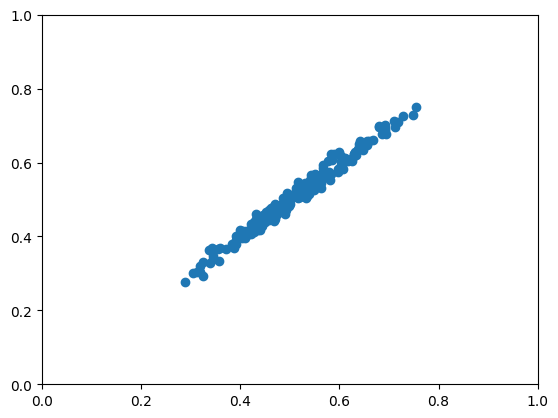

(200, 2)

Cond.Marginal= ['c1'] . Sigma=0.0005. Top.Level=8. Max.Size=None


/Users/giuseppevietri/Code/smartnoise-sdk-gsd/synth/snsynth/gsd/gsd.py:105: UserWarning: Must split privacy budget
  warnings.warn("Must split privacy budget")


Cond.Marginal= ['c2'] . Sigma=0.0005. Top.Level=8. Max.Size=None
	Total size=1020
Cond.Marginal= ['c1', 'c2'] . Sigma=0.0003. Top.Level=5. Max.Size=None
	Total size=1364
Statistics size = 2384
Gen=0   : fitness=2.52814.
Gen=200 : fitness=0.390829.
Gen=400 : fitness=0.0337713.
Gen=600 : fitness=0.0107826.
Gen=800 : fitness=0.00653397.
Gen=1000: fitness=0.00507107.
Gen=1200: fitness=0.00373638.
Gen=1400: fitness=0.00331282.
Gen=1600: fitness=0.00308326.
Gen=1800: fitness=0.00235529.
Gen=2000: fitness=0.00212303.
Gen=2200: fitness=0.00189923.
Gen=2400: fitness=0.00189923.
		 ### Stop early at 2400 ###
Statistical error: 0.0050000000000000044


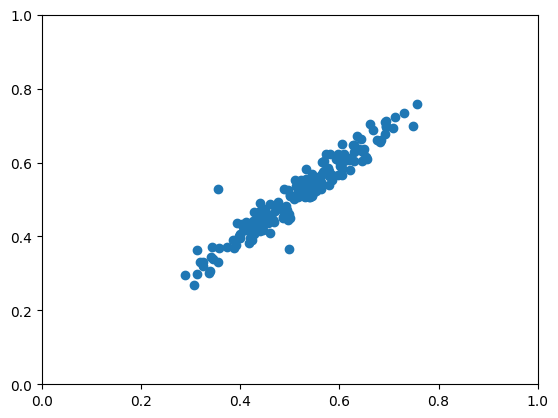

In [3]:
import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

mean = [0.5, 0.5]
cov = [[.01, 0.0099], 
       [0.0099, .01]]  # diagonal covariance

N = 200
d = 5
# data_cont = rng.uniform((N, d))

x, y = np.random.multivariate_normal(mean, cov, N).T
values_cont = np.column_stack((x, y))

plt.title('Real data')
plt.scatter(x, y)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

print(values_cont.shape)
cont_cols = ['c1', 'c2']
data_cont_df = pd.DataFrame(values_cont, columns=cont_cols)
data_bounds = {'c1': {'lower': 0, 'upper': 1}, 'c2': {'lower': 0, 'upper': 1}}

synth = GSDSynthesizer(3000.0, 1e-5, tree_height=8, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(data_cont_df, data_bounds=data_bounds, 
          genetic_operators=['mutate', 'continuous', 'swap'])

max_error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy())).max()
print(f'Statistical error:', max_error)

sync_df = synth.sample()
plt.title('Sync data')
plt.scatter(sync_df['c1'].values, sync_df['c2'].values)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Real-valued low variance

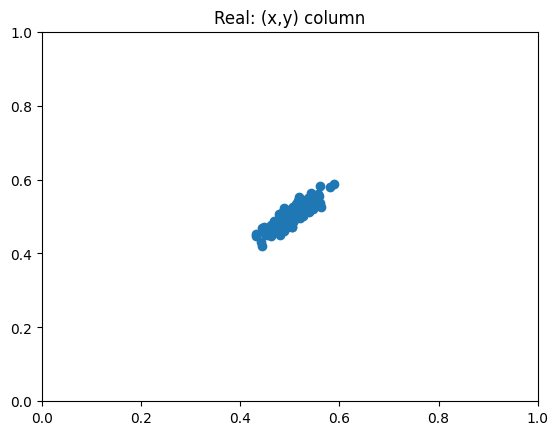

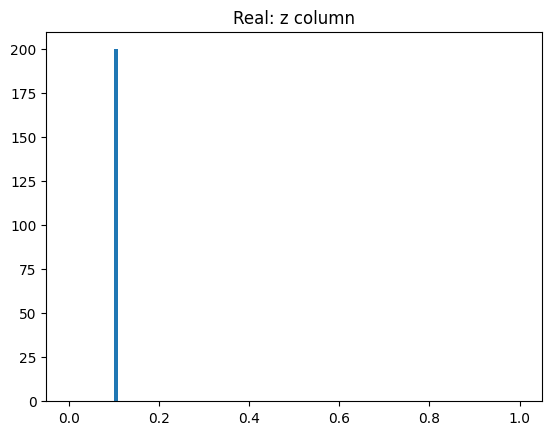

/Users/giuseppevietri/Code/smartnoise-sdk-gsd/synth/snsynth/gsd/gsd.py:105: UserWarning: Must split privacy budget
  warnings.warn("Must split privacy budget")



Cond.Marginal= ['x'] . Sigma=0.0008. Top.Level=12. Max.Size=None
Cond.Marginal= ['y'] . Sigma=0.0008. Top.Level=12. Max.Size=None
Cond.Marginal= ['z'] . Sigma=0.0008. Top.Level=12. Max.Size=None
	Total size=24570
Cond.Marginal= ['x', 'y'] . Sigma=0.0005. Top.Level=5. Max.Size=None
Cond.Marginal= ['x', 'z'] . Sigma=0.0005. Top.Level=5. Max.Size=None
Cond.Marginal= ['y', 'z'] . Sigma=0.0005. Top.Level=5. Max.Size=None
	Total size=4092
Statistics size = 28662
Gen=0   : fitness=19.3456.
Gen=200 : fitness=13.1972.
Gen=400 : fitness=8.54034.
Gen=600 : fitness=5.26597.
Gen=800 : fitness=3.2054.
Gen=1000: fitness=1.99527.
Gen=1200: fitness=1.13676.
Gen=1400: fitness=0.60575.
Gen=1600: fitness=0.269412.
Gen=1800: fitness=0.0970568.
Gen=2000: fitness=0.0355832.
Gen=2200: fitness=0.025257.
Gen=2400: fitness=0.0244788.
Gen=2600: fitness=0.0233713.
Gen=2800: fitness=0.0225871.
Gen=3000: fitness=0.0221786.
Gen=3200: fitness=0.0214574.
Gen=3400: fitness=0.0205548.
Gen=3600: fitness=0.0199049.
Gen=38

In [5]:
# Real-valued data
"""
In some situations the input data in concentrated in a small regions. In these case we must increase 
the granularity of the queries. 
"""


import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

mean = [0.5, 0.5]
cov = [[.001, 0.0009], 
       [0.0009, .001]]  # diagonal covariance

N = 200
d = 5
# data_cont = rng.uniform((N, d))

x, y = np.random.multivariate_normal(mean, cov, N).T
z = 0.1 * np.ones((N, 1))
values_cont = np.column_stack((x, y, z))
cont_cols = ['x', 'y', 'z']
data_cont_df = pd.DataFrame(values_cont, columns=cont_cols)
data_bounds = {'x': {'lower': 0, 'upper': 1}, 'y': {'lower': 0, 'upper': 1}, 'z': {'lower': 0, 'upper': 1} }

plt.title('Real: (x,y) column')
plt.scatter(x, y)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

plt.title('Real: z column')
plt.hist(z, range=(0,1), bins=100)
plt.show()


# Run GSD


synth = GSDSynthesizer(3000.0, 1e-5, tree_height=12, verbose=True)
# Since we are passing the data bounds, we do not need to provide privacy budget for preprocessing.
synth.fit(data_cont_df, data_bounds=data_bounds, 
          genetic_operators=['mutate', 'continuous', 'swap'])
max_error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy())).max()
print(f'Statistical error:', max_error)

sync_df = synth.sample()

x_sync = sync_df['x']
y_sync = sync_df['y']
z_sync = sync_df['z']


# End